# RWCTF Old curve

use [paper](https://eprint.iacr.org/2019/1050.pdf) to help construct the lattice the LLL and the groebner_basis method to find (x, y, z), then using ecm to find **(p-s)** and **(q-r)**
chall.py

In [ ]:
from Crypto.Util.number import bytes_to_long,long_to_bytes
from secret import N,e,p,q,a,b
import os
flag = open('flag','r').read().strip()
assert N == p*q

def padding(msg):
    num = bytes_to_long(msg)
    msg = long_to_bytes(num^^p)
    res = msg
    if len(res) < 128:
        res = res + os.urandom(128-len(res))
    return res

def transfer(msg):
    assert len(msg) < 128
    while True:
        m = padding(msg)
        Mx = Integer(bytes_to_long(m))
        if Mx > N:
            continue
        u = R(pow(Mx,3,N)+a*Mx+b)
        if kronecker(u,p) == 1 and kronecker(u,q) == 1:
            mp = Ep.lift_x(Mx)
            mq = Eq.lift_x(Mx)
            My = crt([Integer(mp[1]),Integer(mq[1])],[p,q])
            return E(Mx,My)

def Stone_Curse(heart):
    stone = e*heart
    return stone

def Lifting_Curse(stone):
    p_order = Ep.order()
    q_order = Eq.order()
    d = inverse_mod(e,lcm(p_order,q_order))
    heart = d*stone
    return heart

if __name__ == "__main__":
    R = Zmod(N)
    E = EllipticCurve(R,[a,b])
    Ep = EllipticCurve(GF(p),[a,b])
    Eq = EllipticCurve(GF(q),[a,b])
    Heart = transfer(flag)
    Stone = Stone_Curse(Heart)
    print Stone
    print N,e
    print a,b

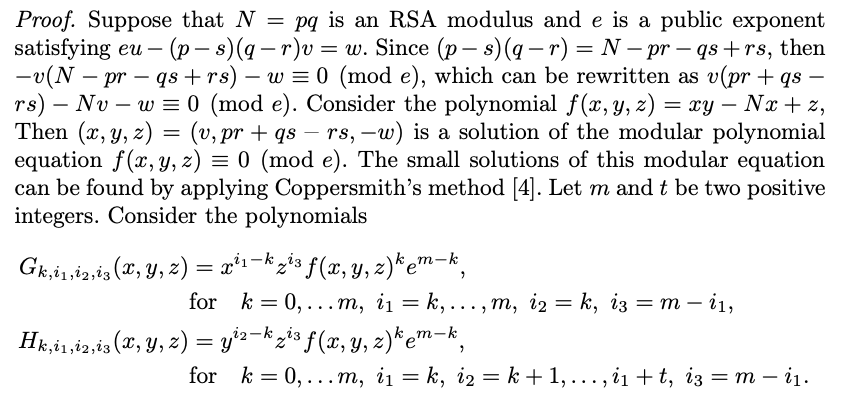

In [ ]:
# display matrix picture with 0 and X
# references: https://github.com/mimoo/RSA-and-LLL-attacks/blob/master/boneh_durfee.sage
def matrix_overview(BB):
    for ii in range(BB.dimensions()[0]):
        a = ('%02d ' % ii)
        for jj in range(BB.dimensions()[1]):
            if BB[ii,jj] == 0:
                a += ' '
            else:
                a += 'X'
            if BB.dimensions()[0] < 60:
                a += ' '
        print(a)
    
def lattice_attack(pol, e, X, Y, Z, mm = 2, tt = 1):
        
    polys = []
    
    for kk in range(mm+1):
        for i1 in range(kk, mm+1):
            i2 = kk
            i3 = mm - i1
            poly = x^(i1 - kk) * z^i3 * pol ^ kk * e ^ (mm - kk)
            polys.append(poly)

    for kk in range(mm+1):
        i1 = kk
        for i2 in range(kk + 1, i1 + tt + 1):
            i3 = mm - i1
            poly = y^(i2 - kk) * z^i3 * pol ^ kk * e ^ (mm - kk)
            polys.append(poly)

    polys = sorted(polys)
    monomials = []
    for poly in polys:
        monomials += poly.monomials()
    monomials = sorted(set(monomials))
    dims1 = len(polys)
    dims2 = len(monomials)
    M = matrix(QQ, dims1, dims2)

    for ii in range(dims1):
        M[ii, 0] = polys[ii](0, 0, 0)
        for jj in range(dims2):
            if monomials[jj] in polys[ii].monomials():
                M[ii, jj] = polys[ii](x * X, y * Y, z * Z).monomial_coefficient(monomials[jj])
                
    matrix_overview(M)
    print()
    print('=' * 128)
    print()
    B = M.LLL()
    print('LLL done')
    matrix_overview(B)
    H = [(i, 0) for i in range(dims1)]
    H = dict(H)
    for j in range(dims2):
        for i in range(dims1):
            H[i] += PR((monomials[j] * B[i, j]) / monomials[j](X, Y, Z))

    H = list(H.values())
    PQ = PolynomialRing(QQ, 'xq, yq, zq')
    xq, yq, zq = PQ.gens()
    for i in range(dims1):
        H[i] = PQ(H[i])

    I = Ideal(*H[1:4])
    xv,yv,zv = var("xq,yq,zq")
    g = I.groebner_basis('giac')[::-1]
    print(solve([g_i(xv,yv,zv) for g_i in g],xv,yv,zv))
    '''
    [xq == r84, yq == r85, zq == r84*r85 - 4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419/3602343035298837553927542062227*r84],
    [xq == r86, yq == (4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419/3602343035298837553927542062227), zq == 0],
    [xq == 0, yq == r87, zq == 0],
    we get xq = 3602343035298837553927542062227
        yq = 4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419//3602343035298837553927542062227 + 1
        zq = xq*yq - 4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419
        assert (xq*yq - N*xq - zq) % e == 0
    '''
    xq = 3602343035298837553927542062227
    yq = 4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419//3602343035298837553927542062227 + 1
    zq = xq*yq - 4298479533919222051278424008577823787364263332580438512213525069157290784423146604914451469507153913893839652272765256923591944212821123404914813182473920184304071161320177981959839398079746158378586359732136948418875022137978872858278664265291581144582621441419
    assert (xq*yq - N*xq - zq) % e == 0
    return xq,yq,zq

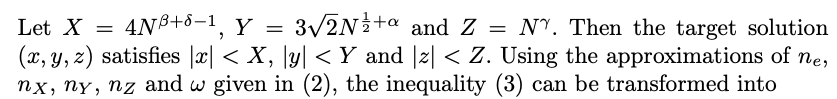
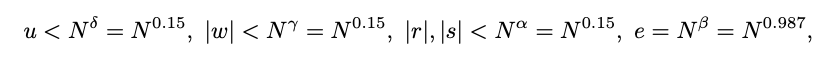

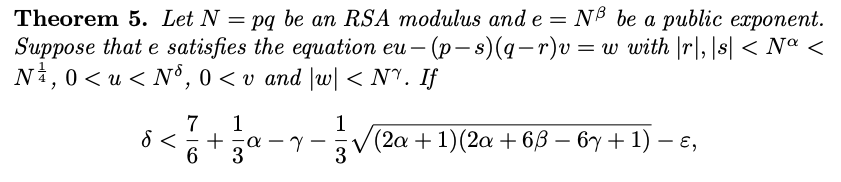

In [105]:
N = 80330528881183983072964816732300543404856810562533626369319300810697262966387144944887576330528743612839739692299784591097332512948890518183519167192046959230085412831864255497489112175176914874596237618253755256608956517757030073479666104923402013469283716999320744856718736837534911809839541660207743594867
e = 78452652317506438607956636739779994986676384637399723342738736371812868831141251164966879331214017314432739387076791674001159059604426825547538902010774841189596518785149221523738464397224366361779781148300651051284198636694801404816891957209985325619623109930150535820404950711233032177848101830061155574970

import math

def bound_check(alpha, beta, gamma, delta):
    cond = 7.0/6 + 1.0/3*alpha - gamma - 1.0/3 * float(sqrt((2*alpha + 1)*(2*alpha + 6*beta - 6*gamma +1))) > delta
    return cond

PR = PolynomialRing(ZZ, 'x, y, z')
x, y, z = PR.gens()

alpha = 0.25
gamma = 0.15
delta = 0.15
beta = math.log2(e) / math.log2(N)

X = math.floor(4*N^(beta + delta - 1))
Y = math.floor(3*sqrt(2)*N^(0.5 + alpha))
Z = math.floor(N^gamma)

# Target polynomial
pol = x*y - N*x - z

mm = 3
t0 = (1  -  2*alpha - 2*delta -  2*gamma) / (2*(1 + 2*alpha))
tt = 1
print(f" bound check : {bound_check(alpha, beta, gamma, delta)} if failed, does not matter")
x0, y0, z0 = lattice_attack(pol, e, X, Y, Z, mm, tt)

False
cond pass
00 X                           
01   X                         
02     X                       
03       X                     
04         X                   
05 X X       X                 
06   X X       X               
07     X X       X             
08         X X     X           
09 X X X     X X     X         
10   X X X     X X     X       
11         X X X   X X   X     
12 X X X X   X X X   X X   X   
13         X X X X X X X X X X 


LLL done
00 X X X X   X X X   X X   X   
01 X X X X   X X X   X X   X   
02 X X X X   X X X   X X   X   
03 X X X     X X     X         
04 X X X X   X X X   X X   X   
05 X X X     X X     X         
06 X X X     X X     X         
07 X X       X                 
08 X X       X                 
09 X                           
10 X X X X X X X X X X X X X X 
11 X X X   X X X   X X   X     
12 X X     X X     X           
13         X                   
[
[xq == r109, yq == r110, zq == r109*r110 - 42984795339192220512784240085778

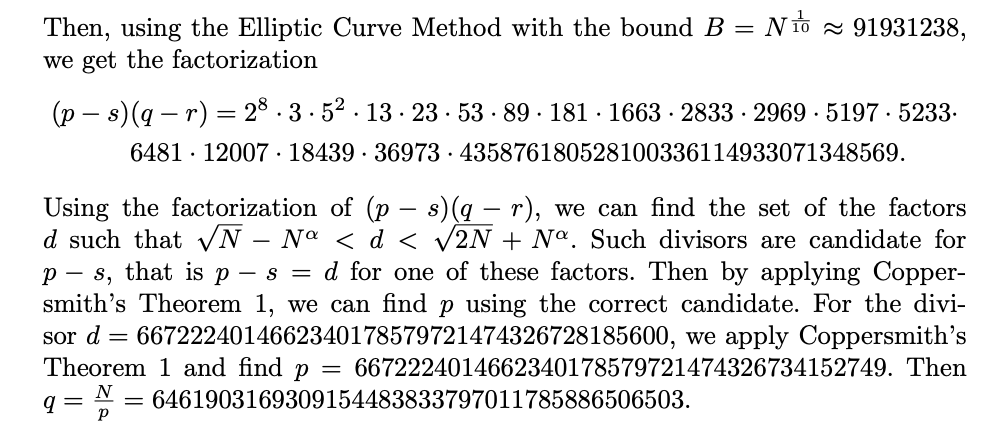

In [115]:
PQ2 = N - y0
factors = ecm.factor(PQ2)
print(factors)
element_length = len(factors)

[11, 13, 131, 131, 227, 251, 251, 831396757, 1108897087, 2178767881, 2253769513, 2698180579, 3504974177, 3752390129, 3787135097, 4166580373, 4192312919, 505386797752007, 14842292277078537617, 15114820929537893567, 15743834086867007131, 120659691081137900860528439558149439256036479214584879088476613192185895986414329679519081477454257879221194033908435726005914629]


In [ ]:
from itertools import combinations
from Crypto.Util.number import long_to_bytes
n_minus_n_alpha = math.floor(sqrt(N)-N^alpha)
sqrt2n_plus_n_alpha = math.floor(sqrt(2*N)+N^alpha)

def Stone_Curse(heart):
    stone = e*heart
    return stone

def Lifting_Curse(store, ps, qr):
    d = inverse_mod(e,lcm(ps,qr))
    heart = d*stone
    return int(heart[0])


a, b  = 3885193323999136856039629631403237736159969409639584250551518536355997978891524564035346751225719460630697433654700022473218421095180111760606245394708999, 944838399254930087523310357339939742097556483183482662977225295067404254966876247970295271959280809100126064366722912020666848894003017117276240476372364
R = Zmod(N)
E = EllipticCurve(R,[a,b])
stone = E((5316297494616251967087180573684467112077977207314228196651011473838683480275875989908990738740861375687186766156200219641981169308660139151062711296717379891376294785675104640775506724244803337279235747630215478504380272738204733311972022712834357078381541224632797503360732934454187646031643331529389570159 ,73177062713968648963738410812785853174528721431172461113561340178691492280271903912043554814810920745154304747328073913103230849027745226637330284520633847773874342467137552022725301429074046921710660867115557994943332628756632246059800601063580017261698262663178072317324978782579376388601713100806653808812))

for i in range(1, element_length - 1):
    flag = 0
    candidates = list(combinations(factors[:-1], i))
    for candidate in candidates:
        qr = factors[-1]*prod(candidate)
        ps = PQ2 // qr
        if n_minus_n_alpha < ps < sqrt2n_plus_n_alpha:
            m_xor_ps = Lifting_Curse(stone, ps, qr)
            for padding in range(0,512,8): # padding range from 0 - 512 s < N^alpha ~ 256bits
                if b"rwctf" in long_to_bytes((m_xor_ps>>padding)^^ps):
                    mp = m_xor_ps >> padding
                    flag = 1
                    fixed = long_to_bytes(mp^^ps)[:-32]
                    guessed = long_to_bytes(mp)[-32:]
                    print(guessed[0])
                    print(fixed)
                    guess = [b"R",b"r",b"3"]
                    '''
                    tH3_CursE_h4S_bR0KEn_o1GIe
                    Alice and Olgierd love each other, but Olgierd's family has fallen on hard times, Alice's parents do not agree to the marriage, the daughter was promised to a foreign prince.Olgierd heartbroken, lost and the devil signed a contract to regain alice's hand, but the devil is often cunning.Olgierd to get back the price of the love of his life is the heart into stone.Olgierd no longer loves alice. he just remembers to love her. Can you help Olgierd lifting the Old Curse(Curve)?
                    '''
                    for g_s in guess:
                        p_pro = (ps>>256<<256)+((ord(g_s)^^guessed[0])<<(256-8))
                        F.<x> = PolynomialRing(Zmod(N), implementation='NTL')
                        poly = p_pro + x
                        x0 = poly.small_roots(X = 2 ** (256-8), beta = 0.45, epsilon = 1/100)
                        if x0:
                            print("flag is :", long_to_bytes(int(p_pro+x0[0])^^mp))
                        else:
                            print("failed")
                    break
    if flag:
        break


62
b'Congratulations!Here is the flag:rwctf{tH3_CursE_h4S_bR0KEn_o1GIe'
flag is : b'Congratulations!Here is the flag:rwctf{tH3_CursE_h4S_bR0KEn_o1GIeRD_ANd_@1iCE_gE7_8AcK_ToG37H3r!}'
failed
failed
62
b'Congratulations!Here is the flag:rwctf{tH3_CursE_h4S_bR0KEn_o1GIe'
